[E-04]TimeSeries_prediction :
- 목적 : 주가 데이터 :시계열 데이터의 추론을 통해 미래의 값을 예측해보자!
- 활용데이터 : stock_prediction 의 005930.KS.csv
- 과정 : 시계열데이터을 stationary 가 보장되도록 분해한다.
분해된 각 특성을 ARIMA 모델을 통해 훈련시키고 주식의 가격을 예측하여 오차율을 확인한다.
- 목표 : 3개 이상의 주식종목에서 MAPE 15% 미만의 정확도를 달성해보자.
*** 

1. 시계열의 안정성이 충분히 확인되었는가?

            플로팅과 adfuller 메소드 사용으로 시계열의 안정성이 (충분히) 확인되는 것을 시각화하였으며, 이에 대한 충분한 설명(해당 메소드에 대한 이해)이 서술되어있음



2. ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가?

            p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨



3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?

            3개 이상 종목이 MAPE 15% 미만의 정확도로 예측됨

# 0. 공통 활용 모듈 import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# 1. 시계열  데이터 준비

- 칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.
- 우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

In [2]:
!pwd

/aiffel/aiffel


In [44]:
# Time Series 생성
filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS_1.csv'
print(filepath)
df = pd.read_csv(filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

/aiffel/aiffel/stock_prediction/data/005930.KS_1.csv


Date
2021-01-04    83000.0
2021-01-05    83900.0
2021-01-06    82200.0
2021-01-07    82900.0
2021-01-08    88800.0
Name: Close, dtype: float64

# 2. 각종 전처리 수행
- 결측치 처리
- 로그 변환

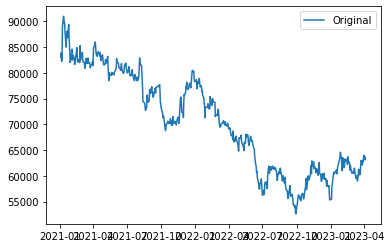

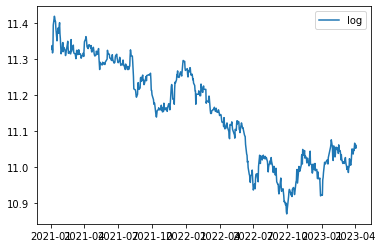

In [45]:
#1. 결측치 처리 -> 처리할 결측치가 없다. 
ts[ts.isna()] #Series([], Name: Close, dtype: float64)
# ts = ts.interpolate(method='time')

#2. 로그변환 
ts_log = np.log(ts)

plt.plot(ts, label='Original')
plt.legend()
plt.show()
plt.plot(ts_log, label='log')
plt.legend()
plt.show()

# 3. 시계열 안정성 분석
- 정성적 그래프 분석
- 정량적 Augmented Dicky-Fuller Test
- 시계열 분해(Time Series Decomposition)
- Residual 안정성 확인

In [46]:
def plot_rolling_statistics(timeseries, window=12):
     
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.show(block=False)
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [47]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

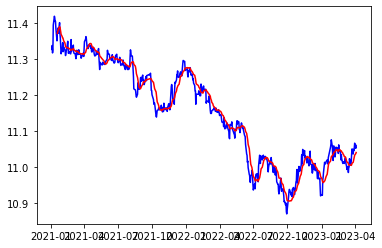

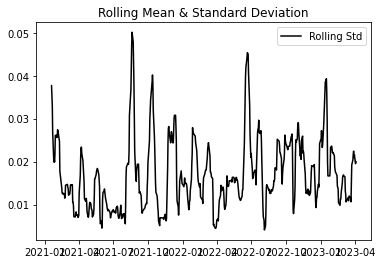

Results of Dickey-Fuller Test:
Test Statistic                  -1.325203
p-value                          0.617565
#Lags Used                       2.000000
Number of Observations Used    553.000000
Critical Value (1%)             -3.442230
Critical Value (5%)             -2.866781
Critical Value (10%)            -2.569561
dtype: float64


In [48]:
 # 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 



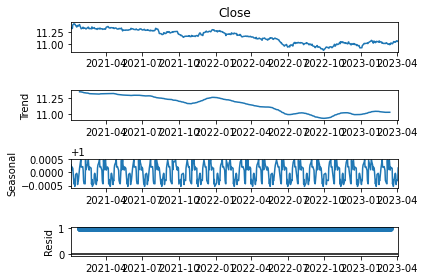

In [49]:
decomposition.plot()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

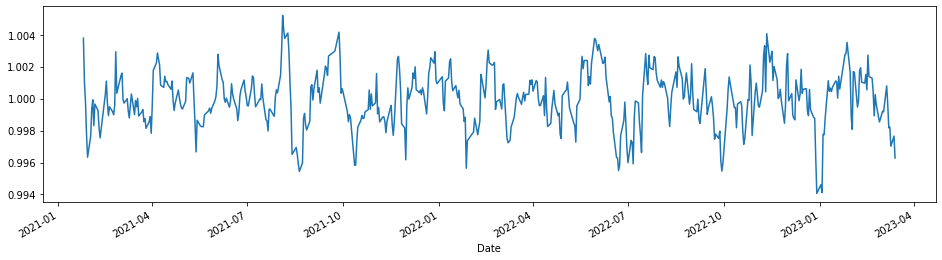

In [50]:
#residual 이 잘 안보여서 다시 확인. 
decomposition.resid.plot(figsize=(16,4))
plt.show

- 어느정도 정상성이 확보된듯하다 (seasonal 제거가 완전히 되었다고 보기 어렵지만)

# 4. 학습, 테스트 데이터셋 생성
- 학습, 테스트 데이터셋 분리

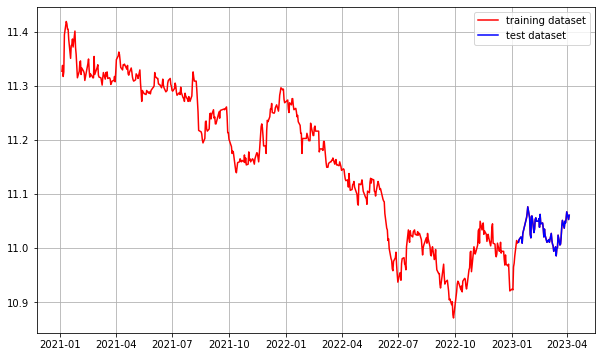

In [51]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# 5. 적정 ARIMA 모수 찾기
- ACF, PACF 그려보기 -> p,q 구하기
- 차분 안정성 확인 -> d 구하기

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


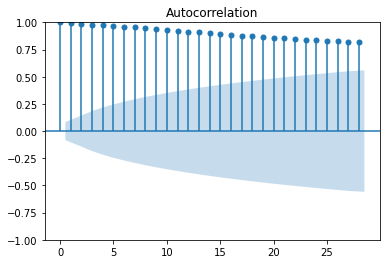

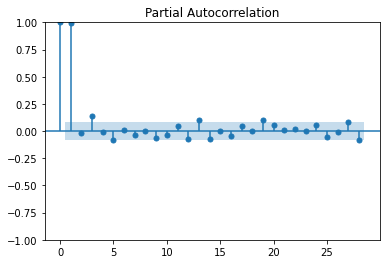

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

#### p,q 설정하기 
- ACF가 완만히 수렴하면서 , partial autocorr 를 보았을 때, p=1 또는 q=1 을 설정해야 한다.  => (p,q) = (0,1), (1,0)
- 이 모형은 AR모형이라고 판단된다. 그러나 pq=0을 유지하면서 점차 p또는 q의 값을 키워 나가볼것이다 
- 왜냐하면, p,q 추정이 ACF, PACF만으로 결정된다고 보기 어려웠기 때문이다. 

Results of Dickey-Fuller Test:
Test Statistic                -1.838267e+01
p-value                        2.207909e-30
#Lags Used                     1.000000e+00
Number of Observations Used    5.530000e+02
Critical Value (1%)           -3.442230e+00
Critical Value (5%)           -2.866781e+00
Critical Value (10%)          -2.569561e+00
dtype: float64


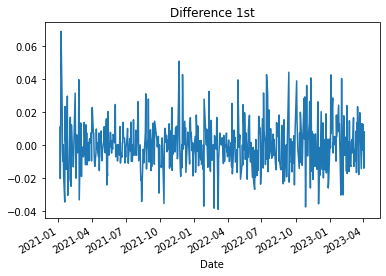

In [12]:

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)


Results of Dickey-Fuller Test:
Test Statistic                -1.150451e+01
p-value                        4.409314e-21
#Lags Used                     1.200000e+01
Number of Observations Used    5.410000e+02
Critical Value (1%)           -3.442495e+00
Critical Value (5%)           -2.866897e+00
Critical Value (10%)          -2.569623e+00
dtype: float64


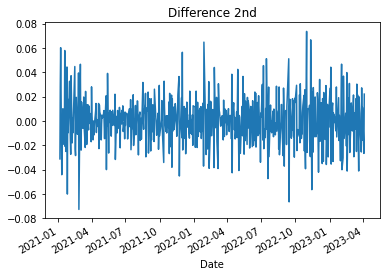

In [13]:
# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

- 차분을 통한 안정성을 확인할 결과, 1차와 2차가 어떤 차이를 가질지 판단하기 어려워서 우선 1차를 활용하기로 했다.   
  => (p,q,d) = (1,0,1) , (0,1,1)이며 p,q는 변경될 수 있다. 

# 6. ARIMA 모델 훈련과 테스트
- ARIMA 모델 빌드와 훈련
- 모델 테스트 및 플로팅
- 최종 예측 모델 정확도 측정(MAPE)


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  500
Model:                 ARIMA(0, 1, 1)   Log Likelihood                1414.759
Date:                Tue, 04 Apr 2023   AIC                          -2825.518
Time:                        02:33:08   BIC                          -2817.093
Sample:                             0   HQIC                         -2822.212
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0121      0.040      0.304      0.761      -0.066       0.090
sigma2         0.0002   9.25e-06     21.803      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.01   Jarque-

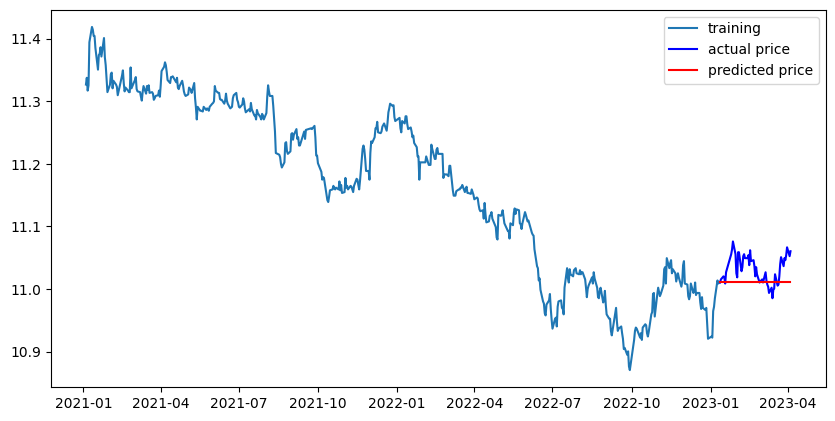

In [14]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(0, 1, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())


# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  500
Model:                 ARIMA(1, 1, 0)   Log Likelihood                1414.757
Date:                Tue, 04 Apr 2023   AIC                          -2825.515
Time:                        02:33:15   BIC                          -2817.089
Sample:                             0   HQIC                         -2822.208
                                - 500                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0079      0.040      0.197      0.843      -0.070       0.086
sigma2         0.0002   9.26e-06     21.795      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.00   Jarque-

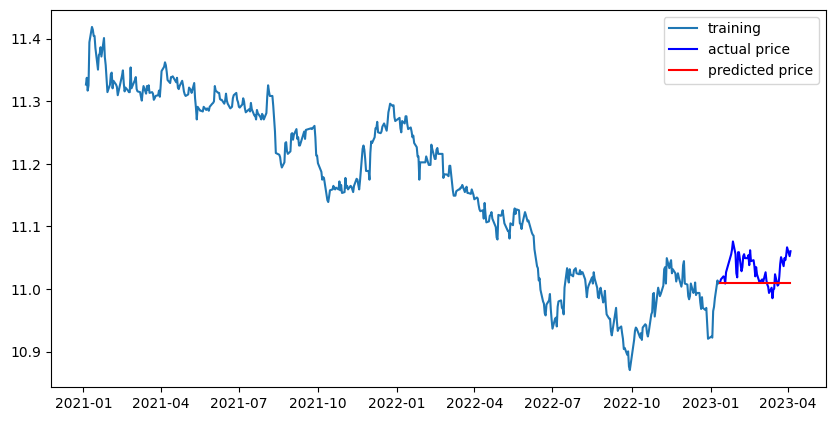

In [15]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit() 

print(fitted_m.summary())

# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

- 위 두 결과를 봤을 떄, pq가 제대로 추정되었다고 보기 어려웠다. 
- 따라서 랜덤값을 다시 부여하였다. 
/

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

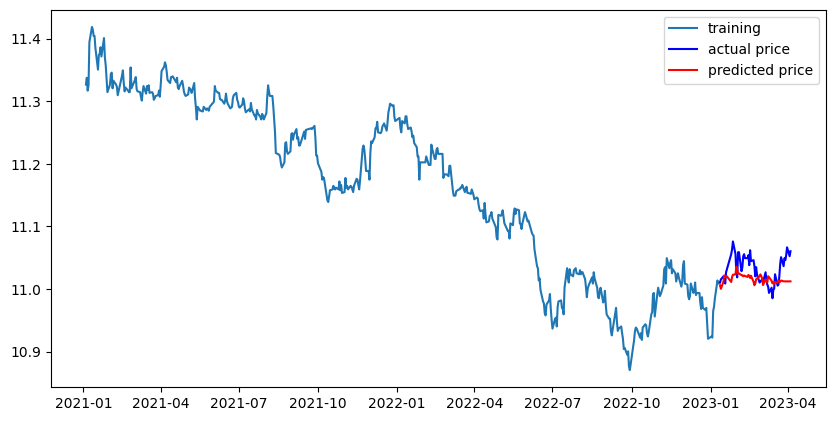

In [52]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(0, 1, 50))  #2.12%
fitted_m = model.fit() 

# print(fitted_m.summary())

fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

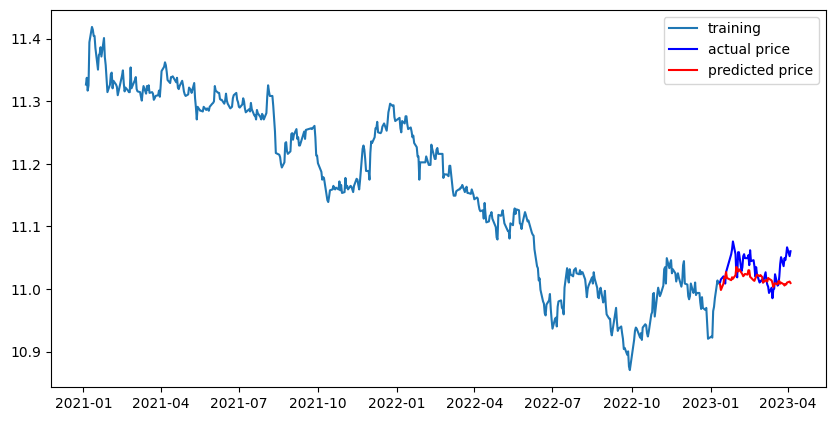

In [54]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(50, 1, 0))  #2.03
fitted_m = model.fit() 

# print(fitted_m.summary())

fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using

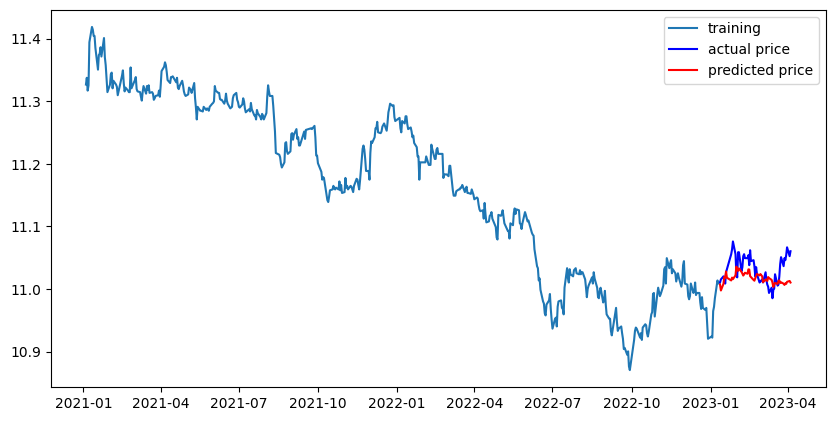

In [56]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(50, 1, 20))  #2.01
fitted_m = model.fit() 

fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

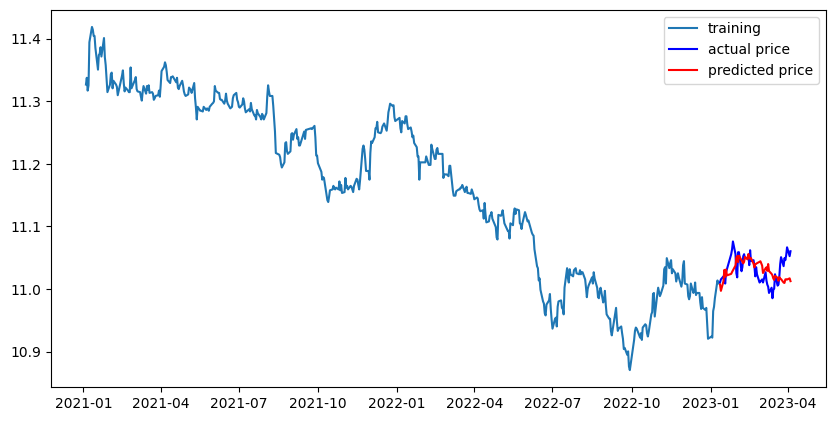

In [58]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(70, 1, 0))  #1.92
fitted_m = model.fit() 

fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

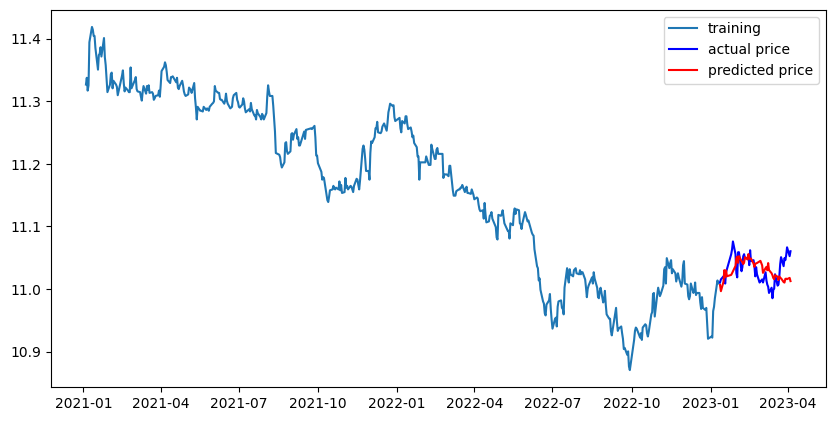

In [60]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(70, 1, 10))  # 1.94
fitted_m = model.fit() 

fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

- p,q 에 0~50 까지 랜덤 수를 부여하여 시각적으로 더 나은 결과는 (p,d,q) = (, 1, ) 였다. 

In [61]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  2144659.672982331
MAE:  1200.0005305723935
RMSE:  1464.4656612506594
MAPE: 1.94%


# 7. 다른 주식 종목 예측해 보기
    위 1~6 번 과정을 반복한다. 

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Time Series 생성
filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/GOOG.csv'
print(filepath)
df = pd.read_csv(filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

/aiffel/aiffel/stock_prediction/data/GOOG.csv


Date
2021-01-04    86.412003
2021-01-05    87.045998
2021-01-06    86.764503
2021-01-07    89.362503
2021-01-08    90.360497
Name: Close, dtype: float64

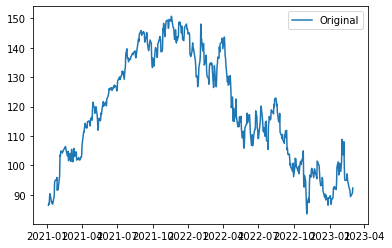

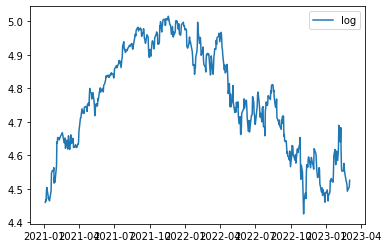

In [63]:
#1. 결측치 처리 -> 처리할 결측치가 없다. 
ts[ts.isna()] #Series([], Name: Close, dtype: float64)
# ts = ts.interpolate(method='time')

#2. 로그변환 
ts_log = np.log(ts)

plt.plot(ts, label='Original')
plt.legend()
plt.show()
plt.plot(ts_log, label='log')
plt.legend()
plt.show()

In [64]:
def plot_rolling_statistics(timeseries, window=12):
     
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.show(block=False)
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

In [65]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

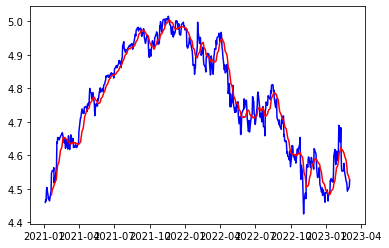

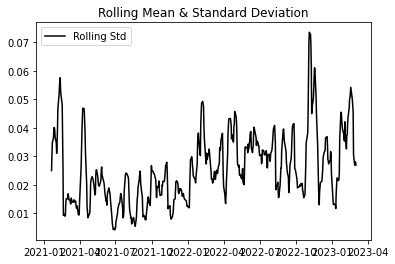

Results of Dickey-Fuller Test:
Test Statistic                  -1.758229
p-value                          0.401388
#Lags Used                       0.000000
Number of Observations Used    543.000000
Critical Value (1%)             -3.442450
Critical Value (5%)             -2.866877
Critical Value (10%)            -2.569613
dtype: float64


In [66]:
 # 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 


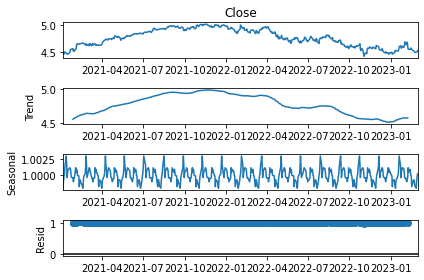

In [67]:
decomposition.plot()
plt.show()

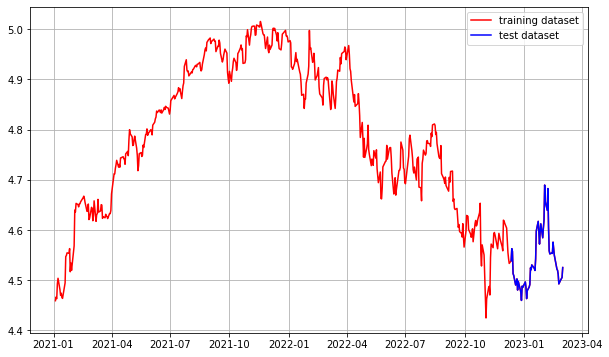

In [68]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


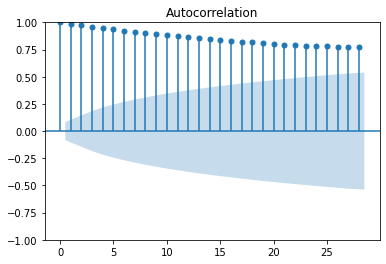

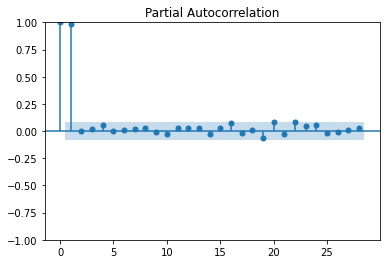

In [69]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

###  p,q 설정하기
위와 마찬가지로
ACF가 완만히 수렴하면서 , partial autocorr 를 보았을 때, p=1 또는 q=1 을 설정해야 한다. => (p,q) = (0,1), (1,0)
이 모형은 AR모형이라고 판단된다. 그러나 pq=0을 유지하면서 점차 p또는 q의 값을 키워 나가볼것이다
왜냐하면, p,q 추정이 ACF, PACF만으로 결정된다고 보기 어려웠기 때문이다.

Results of Dickey-Fuller Test:
Test Statistic                 -23.634743
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    542.000000
Critical Value (1%)             -3.442473
Critical Value (5%)             -2.866887
Critical Value (10%)            -2.569618
dtype: float64


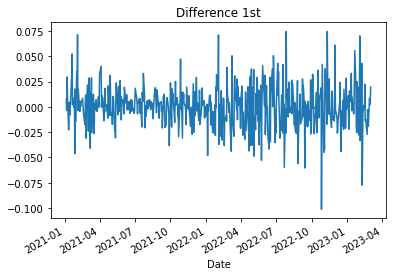

In [70]:

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)


Results of Dickey-Fuller Test:
Test Statistic                -1.040000e+01
p-value                        1.920483e-18
#Lags Used                     1.600000e+01
Number of Observations Used    5.250000e+02
Critical Value (1%)           -3.442867e+00
Critical Value (5%)           -2.867061e+00
Critical Value (10%)          -2.569710e+00
dtype: float64


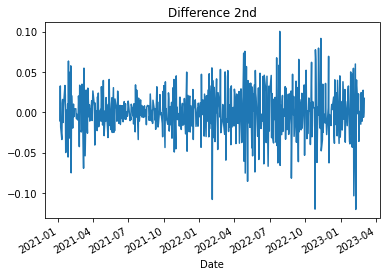

In [71]:

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

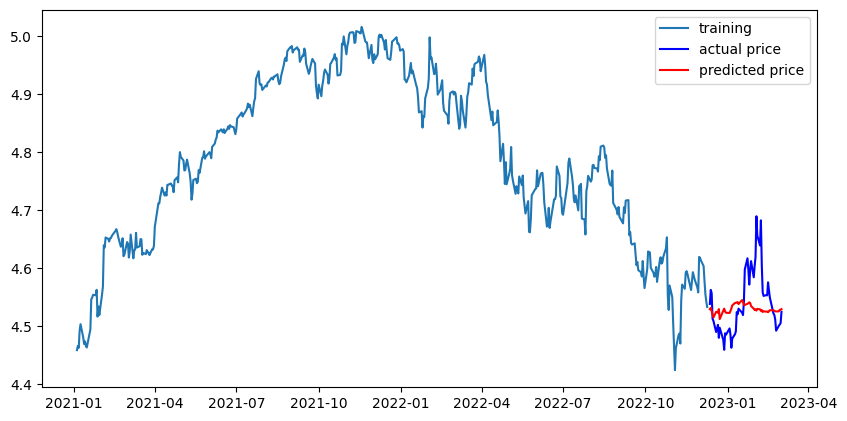

In [77]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(40, 1, 10))  #4.27
fitted_m = model.fit() 

fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

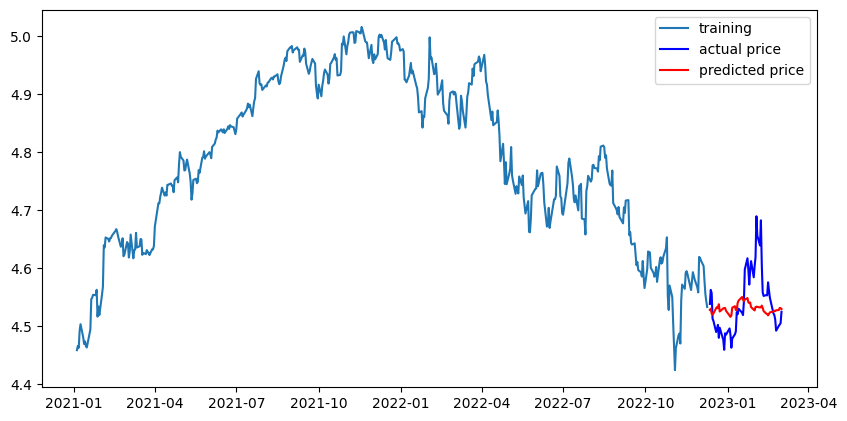

In [81]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(train_data, order=(50, 1, 5))  #4.27
fitted_m = model.fit() 

fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [82]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  27.722083767660457
MAE:  4.122295446410621
RMSE:  5.265176518186305
MAPE: 4.27%


# 7. 회고
- 우선 ARIMA 모델의 p,q 모수를 찾는 방법은 결과만 봤을 때, 최적화를 위한 방법은 아닌듯하다. 거의 랜덤 뽑기여서 하나하나 다 넣어봐야 했다... 
- 노드에서 예제로 진행했던 시계열 분해는 seasonal과 trend 가 명확히 구분되었지만, 실제 데이터로는 분해가 제대로 되지 않아 stationary한 데이터를 얻기 쉽지 않았다. 여러 실험 결과, seasonal에 period를 얼마로 주느냐에 따라 결과가 상당히 달라지는 것을 확인 할 수 있었는데, 이것을 직접 눈으로 확인하지 않는 이상, 설정하기 어려워 보인다. 특히, 대용량의 데이터에서 전부 각각 확인하여 설정하는 것은 거의 불가능할 거 같아서 시계열 분해를 통한 예측은 좀더 많은 연구가 필요한 영역이라고 이해했다. 
- 이번 explolation을 통해서 기존의 주가에 어느정도 설명가능하게 예측했느냐를 판단하기에는 평가지표 만으로는 많이 부족해보였다.
- 시각적으로 실제값과 가까워 졌다고 느껴도 mape 가 크게 줄어들지 않았다 -> mape 의 단점으로 지적되었던 0에 가까워 질수록 오류가 커진다는 것이 적용된 것이 아닐까 생각된다. 